## Chesapeake Bay Bloom 2025 (July 21) - Looking at the Rrs Spectra

Login to NASA Earth Access

In [1]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

Select the date and set the ROI bbox

In [3]:
bbox = (-76.903, 37.873, -75.608, 39.659)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L2_AOP",
    temporal = ("2024-08-27", "2024-08-27"),
    bounding_box = bbox
)

len(results)

1

In [4]:
# look at the file names to make sure they are ok
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240827T175938.L2.OC_AOP.V3_1.nc']]

In [5]:
fileset = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

This is level 2 data and unlike level 3 data, it has groups. We need to use `open_datatree()` and `merge().

In [6]:
# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False, chunks={}) 
datatree.groups

('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

In [7]:
# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1709,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    latitude       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/30)
    wavelength     (number_of_bands) float64 2kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_gain      (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_offset    (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    F0             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    aw             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    bbw            (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    ...             ...
    aot_865        (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    angstrom       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    avw            (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    nflh           (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    tilt           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
Attributes: (12/47)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20240827T175938.L2.OC_AOP.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data5/sdpsoper/vdc/vpu24/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -104.11461
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9798871874809265
    geospatial_bounds:                 POLYGON ((-67.05899 53.53644, -104.114...

In [8]:
# Fix a chunk mismatch and check the chunking; ignore the warning
# We are good for dask backed operations
ds = ds.unify_chunks()
ds.chunks

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/structure/chunks.py:180: PerformanceWarning: Increasing number of chunks by factor of 81
  _, chunked_data = chunkmanager.unify_chunks(*unify_chunks_args)


Frozen({'number_of_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_reflective_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_lines': (32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13), 'pixels_per_line': (256, 256, 256, 256, 248), 'wavelength_3d': (40, 40, 40, 40, 12)})

## Let's open it up!

Let's load up our libraries, and then extract the relevant data we need. 

In [9]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize

In [10]:
# Assign core variables; for convenience during plotting
rrs_da = ds["Rrs"]
avw_da = ds["avw"]
wavelengths = ds["wavelength_3d"]

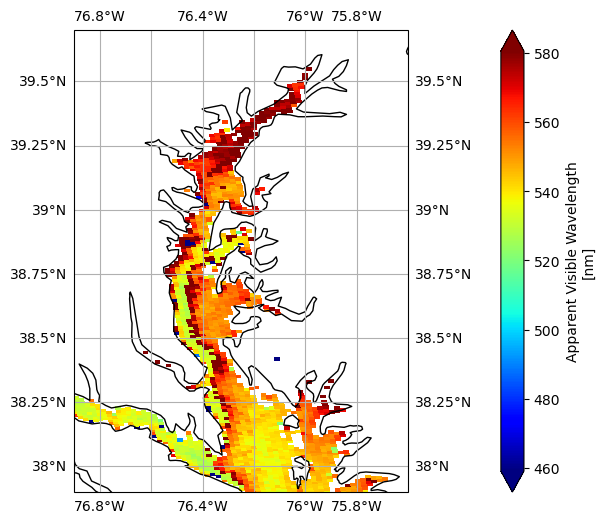

In [11]:
# This first part helps get rid of outliers that might mess up your plot
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

# Get the figure set up, add a map projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Put some lines in there so we know where we are
ax.gridlines(draw_labels=True)
ax.coastlines()

# Crop the image down a bit so we can focus on an area
ax.set_extent([-76.9, -75.6, 37.9, 39.7], crs=ccrs.PlateCarree())

# Plot and adjust colorbar limits, put "pad" argument in there to move the colorbar away from the image (otherwise it overlaps)
img = avw_da.plot(x="longitude", y="latitude", cmap="jet", vmin=vmin, vmax=vmax, ax=ax, cbar_kwargs={"pad": 0.1})


fig.savefig(
    'AVW_27082024_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)


In [12]:
# This takes a few seconds to run
# rrs_da is a dask array (chunked). We use .compute() for force it to compute now
brightness = rrs_da.integrate(coord='wavelength_3d').compute()

Let's just do a quick comparison of the two spectral rasters - AVW (focused on spectral shape), and brightness (focused on spectral magnitude).

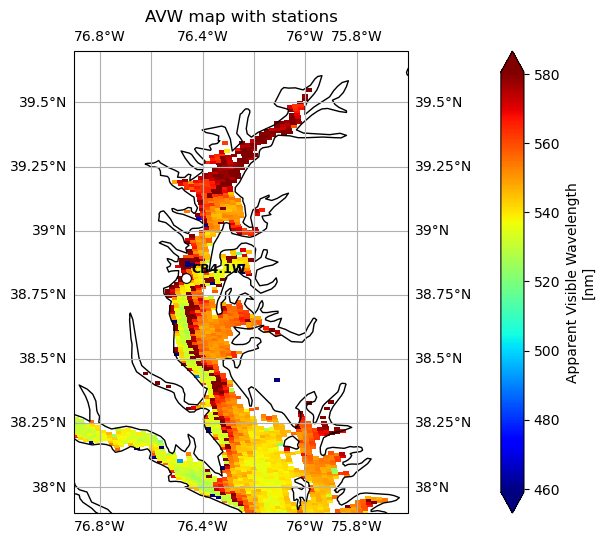

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Outlier clipping
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

#vmin_q = float(avw_da.quantile(0.01))
#vmax_q = float(avw_da.quantile(0.99))

#vmin = max(520, vmin_q)   # don’t let the colorbar start below 520
#vmax = vmax_q

# Figure with map projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Gridlines and coastlines
ax.gridlines(draw_labels=True)
ax.coastlines()

# Crop map to region of interest
ax.set_extent([-76.9, -75.6, 37.9, 39.7], crs=ccrs.PlateCarree())

# Plot the data
img = avw_da.plot(
    x="longitude",
    y="latitude",
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
    ax=ax,
    cbar_kwargs={"pad": 0.1}
)

# Stations
stations = [
    ("CB4.1W", 38.8149,-76.4627),
]


# Overlay station points
for name, lat, lon in stations:
    ax.scatter(lon, lat, s=50, color="white", edgecolor="black", linewidth=0.8, zorder=5)
    ax.text(lon + 0.02, lat + 0.02, name, fontsize=9, color="black", fontweight="bold", zorder=6)

plt.title("AVW map with stations")
fig.savefig(
    'AVW_WithStations_27082024_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

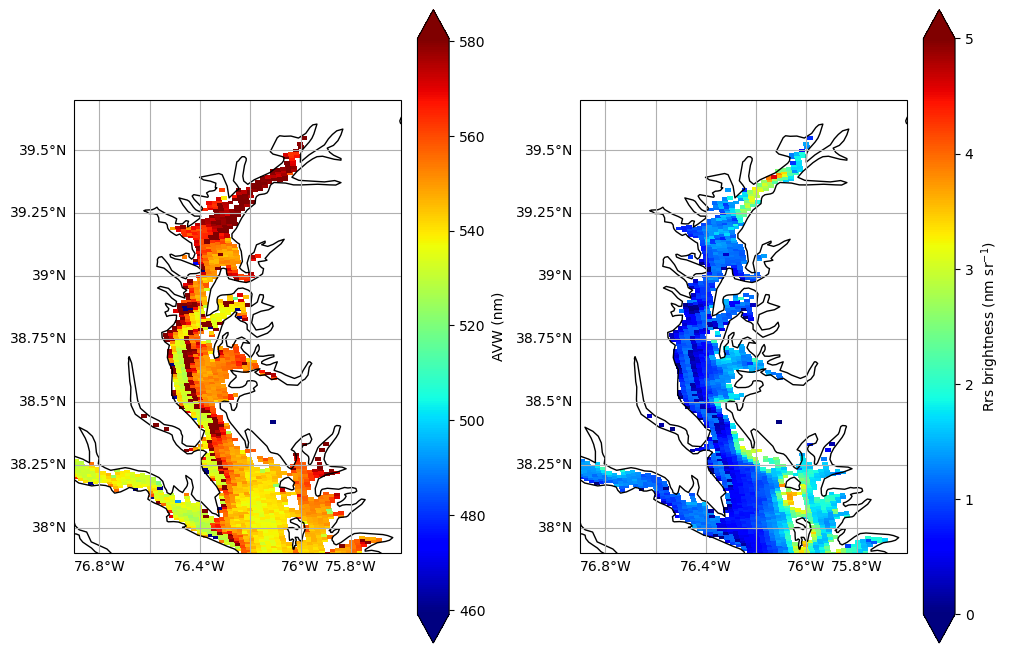

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# This first part helps get rid of outliers that might mess up your plot
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

# AVW
avw_da.plot(ax=axes[0], x="longitude", y="latitude",cmap="jet", vmin=vmin, vmax=vmax,
    cbar_kwargs={"shrink": 0.8, "label": "AVW (nm)"})
axes[0].set_extent([-76.9, -75.6, 37.9, 39.7])
axes[0].coastlines()
axes[0].gridlines(draw_labels={"bottom": "x", "left": "y"})

# Brightness
brightness.plot(ax=axes[1], x="longitude", y="latitude", cmap="jet", vmin=0, vmax=5,
    cbar_kwargs={"shrink": 0.8, "label": "Rrs brightness (nm sr$^{-1}$)"})
axes[1].set_extent([-76.9, -75.6, 37.9, 39.7])
axes[1].coastlines()
axes[1].gridlines(draw_labels={"bottom": "x", "left": "y"})

fig.savefig(
    'AVW_RrsBrightness_27082024_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

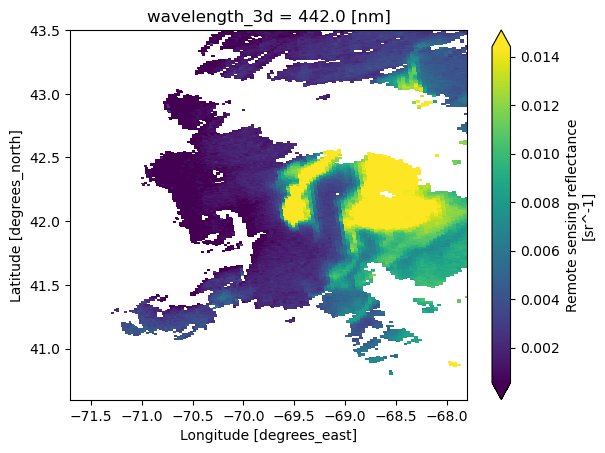

In [16]:
# Plot
rrs = ds['Rrs'].sel(
    wavelength_3d=443,  method='nearest')
rrs.plot(robust=True, 
         x="longitude", y="latitude",
         xlim=(-71.7, -67.8), ylim=(40.6, 43.5));


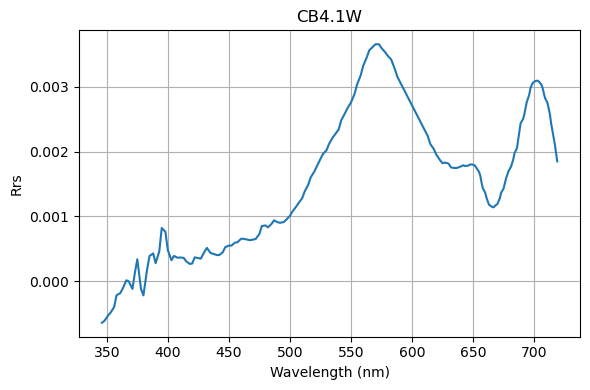

In [27]:
# Lat/lon grids
lat_grid = ds["latitude"].values
lon_grid = ds["longitude"].values

# Choose ONE station (e.g. first one)
stations = [
    ("CB4.1W", 38.8149,-76.4627),
]

name, plat, plon = stations[0]

# Compute distances to all pixels
dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
y, x = np.unravel_index(dist.argmin(), dist.shape)

# Extract spectrum
spectrum = ds["Rrs"].isel(number_of_lines=y, pixels_per_line=x)

# Single plot
fig, ax = plt.subplots(figsize=(6, 4))

spectrum.plot.line(x="wavelength_3d", ax=ax)
ax.set_title(name)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Rrs")
ax.grid(True)

# Optional limits
# ax.set_ylim(-0.006, 0.002)
# ax.set_xlim(350, 750)

fig.tight_layout()
fig.savefig(
    'Spectrum_27082024_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()


Add the rhos spectra too

In [19]:

import xarray as xr
results_rhos = earthaccess.search_data(
    short_name = "PACE_OCI_L2_SFREFL",
    temporal = ("2024-08-27", "2024-08-27"),
    bounding_box = bbox
)

len(results_rhos)

1

In [21]:
# look at the file names to make sure they are ok
[res.data_links() for res in results_rhos]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240827T175938.L2.SFREFL.V3_1.nc']]

In [22]:
fileset_rhos = earthaccess.open(results_rhos);

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# open_datatree is for netcdf files with groups
datatree_rhos = xr.open_datatree(fileset_rhos[0], decode_timedelta=False, chunks={}) 
datatree_rhos.groups

('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

In [24]:
# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds_rhos = xr.merge(datatree_rhos.to_dict().values())
ds_rhos = ds_rhos.set_coords(("longitude", "latitude"))
ds_rhos

<xarray.Dataset> Size: 1GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 122, number_of_lines: 1709,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    latitude       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/25)
    wavelength     (number_of_bands) float64 2kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_gain      (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_offset    (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    F0             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    aw             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    bbw            (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    ...             ...
    clat           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
    elat           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
    csol_z         (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
    rhos           (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB dask.array<chunksize=(32, 256, 40), meta=np.ndarray>
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    tilt           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
Attributes: (12/47)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20240827T175938.L2.SFREFL.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data12/sdpsoper/vdc/vpu11/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -104.11461
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9798871874809265
    geospatial_bounds:                 POLYGON ((-67.05899 53.53644, -104.114...

In [25]:
# Fix a chunk mismatch and check the chunking; ignore the warning
# We are good for dask backed operations
ds_rhos = ds_rhos.unify_chunks()
ds_rhos.chunks

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/structure/chunks.py:180: PerformanceWarning: Increasing number of chunks by factor of 81
  _, chunked_data = chunkmanager.unify_chunks(*unify_chunks_args)


Frozen({'number_of_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_reflective_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_lines': (32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13), 'pixels_per_line': (256, 256, 256, 256, 248), 'wavelength_3d': (40, 40, 40, 2)})

In [29]:
# Assign core variables; for convenience during plotting
rhos_da = ds_rhos["rhos"]

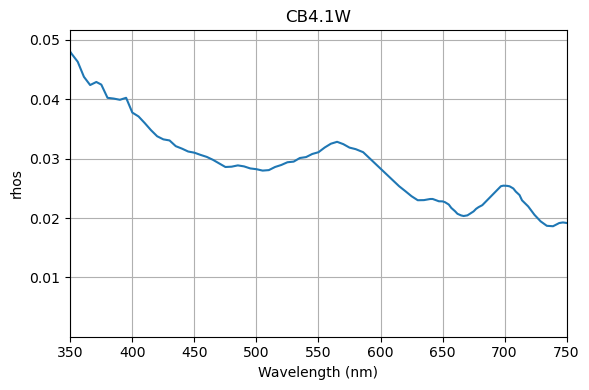

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Choose ONE station
stations = [
    ("CB4.1W", 38.8149,-76.4627),
]

name, plat, plon = stations[0]

# Lat/lon grids
lat_grid = ds_rhos["latitude"].values
lon_grid = ds_rhos["longitude"].values

# Compute distances to all pixels
dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
y, x = np.unravel_index(dist.argmin(), dist.shape)

# Extract spectrum
spectrum = ds_rhos["rhos"].isel(number_of_lines=y, pixels_per_line=x)

# Single plot
fig, ax = plt.subplots(figsize=(6, 4))

spectrum.plot.line(x="wavelength_3d", ax=ax)
ax.set_title(name)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("rhos")
ax.set_xlim(350, 750)
ax.grid(True)

# Optional limits
# ax.set_ylim(-0.006, 0.002)

fig.tight_layout()
fig.savefig(
    'Spectrum_rhos_CB3.3W_27082024_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()


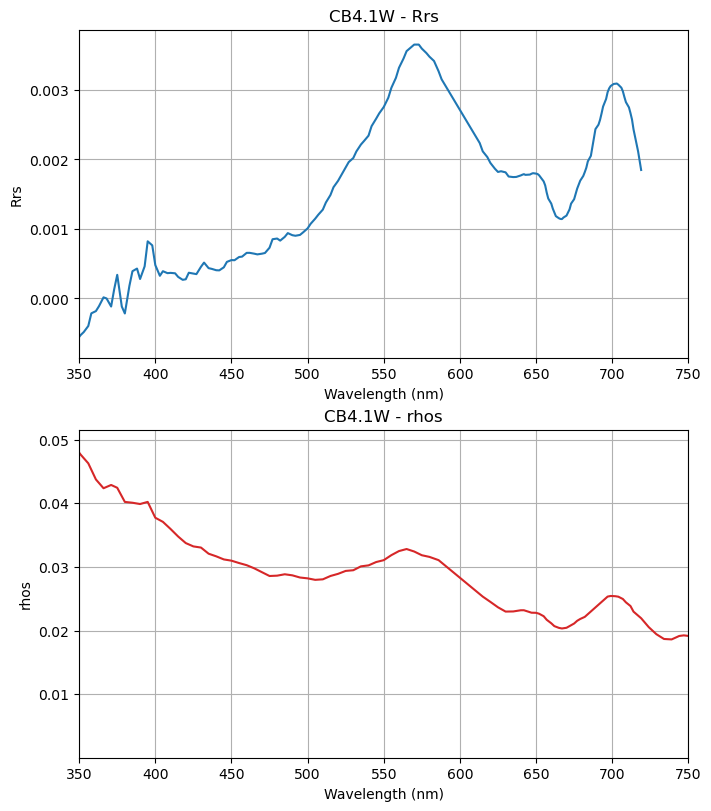

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Station
stations = [("CB4.1W", 38.8149, -76.4627)]
name, plat, plon = stations[0]

# --------------------
# Lat/lon grids
# --------------------
lat_grid_rrs = ds["latitude"].values
lon_grid_rrs = ds["longitude"].values

lat_grid_rhos = ds_rhos["latitude"].values
lon_grid_rhos = ds_rhos["longitude"].values

# --------------------
# Find nearest pixel (Rrs)
# --------------------
dist_rrs = np.sqrt((lat_grid_rrs - plat)**2 + (lon_grid_rrs - plon)**2)
y_rrs, x_rrs = np.unravel_index(dist_rrs.argmin(), dist_rrs.shape)
spectrum_rrs = ds["Rrs"].isel(number_of_lines=y_rrs, pixels_per_line=x_rrs)

# --------------------
# Find nearest pixel (rhos)
# --------------------
dist_rhos = np.sqrt((lat_grid_rhos - plat)**2 + (lon_grid_rhos - plon)**2)
y_rhos, x_rhos = np.unravel_index(dist_rhos.argmin(), dist_rhos.shape)
spectrum_rhos = ds_rhos["rhos"].isel(number_of_lines=y_rhos, pixels_per_line=x_rhos)

# --------------------
# Plot
# --------------------
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 8), constrained_layout=True)

# Rrs subplot
spectrum_rrs.plot.line(x="wavelength_3d", ax=axes[0])
axes[0].set_title(f"{name} - Rrs")
axes[0].set_xlabel("Wavelength (nm)")
axes[0].set_ylabel("Rrs")
axes[0].set_xlim(350, 750)
axes[0].grid(True)

# rhos subplot
spectrum_rhos.plot.line(x="wavelength_3d", ax=axes[1], color="tab:red")
axes[1].set_title(f"{name} - rhos")
axes[1].set_xlabel("Wavelength (nm)")
axes[1].set_ylabel("rhos")
axes[1].set_xlim(350, 750)
axes[1].grid(True)

# Save figure
fig.savefig(
    'Spectrum_Rrs_rhos_27082024_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()
